<a href="https://colab.research.google.com/github/pedroafleite/mobiauto/blob/main/car_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mobiauto: Análise de Dados e Predição


https://smolski.github.io/livroavancado/regressao-com-dados-em-painel.html

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn # ignorar alertas irritantes do jupyter notebook

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Descrição dos dados

In [3]:
car = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/car_data/car_data.csv')
car.head(5)

,createdat,make,model,modelyear,fipe_price,price,km,region,phonearea,color,engine,bodystyle,fuel
0,2020-10-01T00:04:06Z,Ford,Ka,2019,47482.0,49900.0,25241.0,SP,11,Cinza,1.5,Hatch,Flex
1,2020-10-01T00:44:06Z,Hyundai,ix35,2019,86978.0,89900.0,23000.0,RJ,21,Branco,2.0,SUV,Flex
2,2020-10-01T01:05:18Z,Volkswagen,Saveiro,2014,32554.0,36900.0,59650.0,PR,41,Branco,1.6,Picapes,Flex
3,2020-10-01T01:05:41Z,Chevrolet,Prisma,2013,31612.0,31900.0,123570.0,PR,41,Branco,1.0,Sedan,Flex
4,2020-10-01T01:08:43Z,Fiat,Uno,2015,28313.0,29890.0,63111.0,RJ,21,Branco,1.0,Hatch,Flex


In [4]:
car.shape # lines, columns

(385856, 13)

In [5]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385856 entries, 0 to 385855
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   createdat   385856 non-null  object 
 1   make        385856 non-null  object 
 2   model       385856 non-null  object 
 3   modelyear   385856 non-null  int64  
 4   fipe_price  363229 non-null  float64
 5   price       385620 non-null  float64
 6   km          383192 non-null  float64
 7   region      385856 non-null  object 
 8   phonearea   385856 non-null  int64  
 9   color       385856 non-null  object 
 10  engine      378915 non-null  object 
 11  bodystyle   385856 non-null  object 
 12  fuel        385856 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 38.3+ MB


In [6]:
car.isna().sum()

createdat         0
make              0
model             0
modelyear         0
fipe_price    22627
price           236
km             2664
region            0
phonearea         0
color             0
engine         6941
bodystyle         0
fuel              0
dtype: int64

In [7]:
car.describe(include="all")

,createdat,make,model,modelyear,fipe_price,price,km,region,phonearea,color,engine,bodystyle,fuel
count,385856,385856,385856,385856.000000,3.632290e+05,3.856200e+05,3.831920e+05,385856,385856.000000,385856,378915,385856,385856
unique,351748,57,657,NaN,NaN,NaN,NaN,27,NaN,18,208,10,3
top,2020-10-06T05:54:43Z,Chevrolet,Onix,NaN,NaN,NaN,NaN,SP,NaN,Branco,1.0,Hatch,Flex
freq,21,63178,20467,NaN,NaN,NaN,NaN,169524,NaN,117228,112755,155861,334799
mean,NaN,NaN,NaN,2016.182680,5.360196e+04,6.040425e+04,9.287483e+12,NaN,30.571379,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,10.882551,3.979747e+04,1.811296e+06,3.119260e+15,NaN,21.814351,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,5.107000e+03,0.000000e+00,0.000000e+00,NaN,11.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,2014.000000,3.437000e+04,3.490000e+04,2.835200e+04,NaN,11.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,2017.000000,4.278600e+04,4.498000e+04,4.761400e+04,NaN,21.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,2019.000000,6.245600e+04,6.599000e+04,8.334900e+04,NaN,43.000000,NaN,NaN,NaN,NaN


O preço dos carros tendem a ser um pouco mais altos do que o preço listado na Fipe. Vamos entender os motivos.


### Tabela Fipe

## Análise Exploratória dos Dados

### Matriz de correlação

In [8]:
car.dropna
categories = ['make', 'model', 'region', 'phonearea', 'color', 'bodystyle', 'fuel']
df_encoded = car.copy(deep=True)

In [9]:
from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
for col in categories:
        df_encoded[col] = lab_enc.fit_transform(car[col])
        name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))

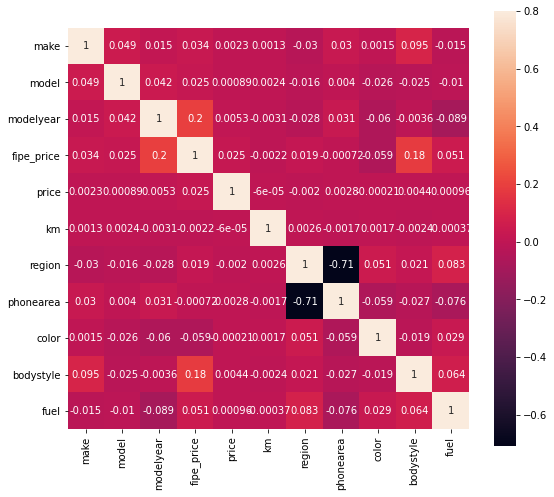

In [10]:
# correlation matrix (heatmap)
corrmat = df_encoded.corr()
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(corrmat, vmax=.8, square=True, cbar=True, annot=True);

A partir da matriz de correlação acima, podemos tirar as seguintes conclusões:
- A variável **price** não apresenta boas correlações com nenhuma outra variável.
- **km** também não apresenta correlações significativas.
- A correlação entre **fipe_price** e **price** não parece tão relevante no heatmap. 
- **fipe_price** possui maior correlação com **modelyear** e **bodystyle**.
- Alta correlação entre **bodystyle**, **fipe_price** e **make**.
- **modelyear** apresenta correlação com **phonearea** e **fuel**.
- Óbvia correlação entre **region** e **phonearea**.

### Preços

Existem carros sendo vendidos por até mais de 2 milhões. Nestes casos, podem ser carros raros, modificados, com determinados acessórios, entre outros motivos. Para termos uma noção compreensiva da distribuição de preços de veículos razoavelmente comuns, nos manteremos na faixa entre 0-150 mil reais. 

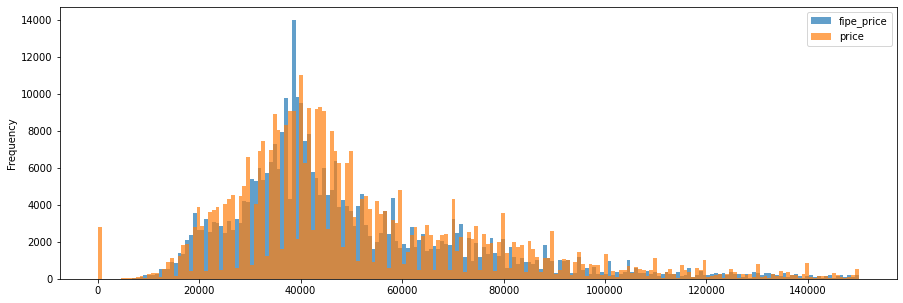

In [11]:
# histogram
car[['fipe_price', 'price']].plot(kind='hist', alpha=0.7, bins=200, range=[0,1.5*10**5], figsize=(15,5));

Aparentemente, existe uma boa convergência entre os dados dos anúncios e os dados da Tabela Fipe. No entanto, existe uma tendência dos preços dos anúncios de serem arredondados. Desta forma, preços de anúncios tendem por vezes a parecer valores discretos, devido à tendência comportamental de arredondar preços em múltiplos de 5 ou 10, ou em algorismos terminados em 99.

In [12]:
# skewness and kurtosis
print("Preços anunciados")
print("Assimetria: %f" % car['price'].skew())
print("Curtose: %f" % car['price'].kurt())
print("======")
print("Preços da Tabela Fipe")
print("Assimetria: %f" % car['fipe_price'].skew())
print("Curtose: %f" % car['fipe_price'].kurt())

Preços anunciados
Assimetria: 599.943643
Curtose: 367222.152728
Preços da Tabela Fipe
Assimetria: 7.671094
Curtose: 187.749246


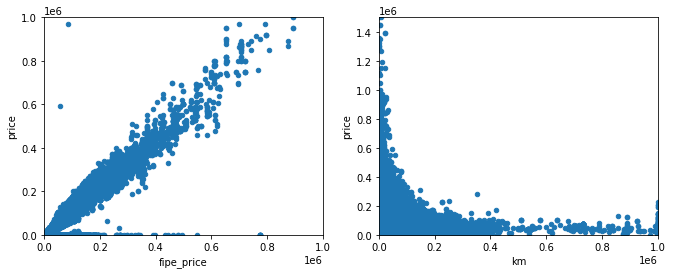

In [13]:
# scatter plot 
data = pd.concat([car['price'], car['fipe_price'], car['km']], axis=1)

fig, ax = plt.subplots(1, 2, figsize=(11,4))
data.plot.scatter(x='fipe_price', y='price', xlim=(0,10**6), ylim=(0,10**6), ax=ax[0])
data.plot.scatter(x='km', y='price', xlim=(0,10**6), ylim=(0,1.5*10**6), ax=ax[1]);

In [14]:
data.plot.scatter(x='km', y='price', xlim=(0,10**6), ylim=(0,1.5*10**6), ax=ax[0]);

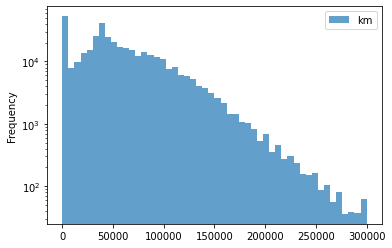

In [15]:
car[['km']].plot(kind='hist', alpha=0.7, bins=50, range=[0,3*10**5]).set_yscale('log');

### Fabricante

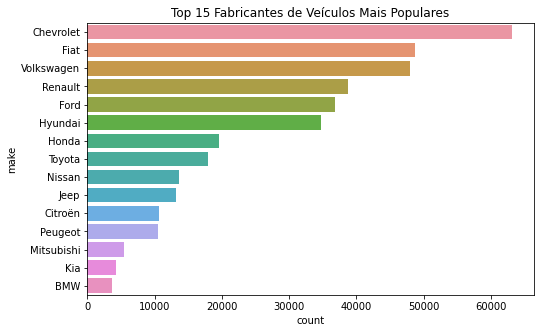

In [16]:
plt.subplots(figsize=(8,5))
sns.countplot(y = car['make'], order=car['make'].value_counts().nlargest(15).index).set_title('Top 15 Fabricantes de Veículos Mais Populares');

### Região e Tipo de Carro

Existem diversos fatores para que um carro seja vendido com um valor diferente ao da Tabela Fipe. Um fator importante a ser considerado é que o Brasil possui diversas regiões geográficas com características sócio-econômicas diferentes. Por exemplo, as regiões norte e sudeste possuem renda per capita bastante diferente, o que influi no preço dos veículos. Ou então, um carro potente como uma picape pode ser mais caro ou mais popular nas extensas áreas agricultáveis do Centro-Oeste, devido a sua maior utilidade nestas regiões. Vamos comparar, por exemplo, os tipos (*bodystyles*) de carro mais populares nos estados de Mato Grosso e São Paulo (figura abaixo). Neste caso, de fato, picapes são relativamente mais populares no Estado de MT do que em SP. 

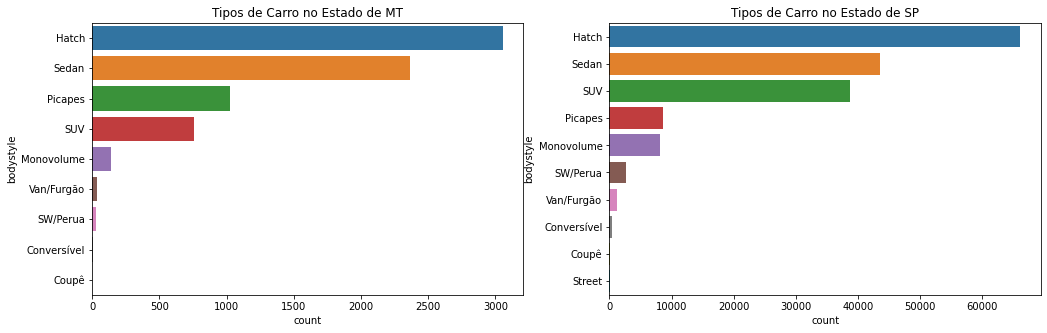

In [17]:
car_mt = car.loc[car.region=='MT']
car_sp = car.loc[car.region=='SP']

fig, ax = plt.subplots(1, 2, figsize=(17,5))
sns.countplot(y = car_mt['bodystyle'], order=car_mt['bodystyle'].value_counts().index, ax=ax[0]);
sns.countplot(y = car_sp['bodystyle'], order=car_sp['bodystyle'].value_counts().index, ax=ax[1]);
ax[0].set_title('Tipos de Carro no Estado de MT');
ax[1].set_title('Tipos de Carro no Estado de SP');

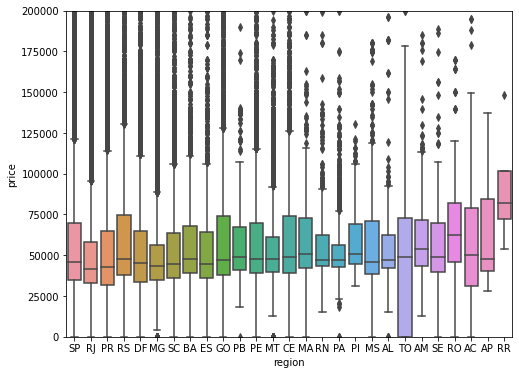

In [18]:
#box plot price/region
data = pd.concat([car['price'], car['region']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='region', y='price', data=data)
fig.axis(ymin=0, ymax=200000);

Outras circunstâncias geográficas podem afetar os preços dos carros. Assim, regiões litorâneas que são afetadas pelos efeitos da maresia podem ter seus carros vendidos a preços mais baixos, pois os carros enferrujam mais rapidamente. No entanto, não podemos testar hipótese com razoabilidade, já que o conjunto de dados não segrega veículos que rodaram especificamente no litoral.

### Motor

In [19]:
# engine
print('Tipos diferentes de motores no dataset:', len(car['engine'].unique()))

Tipos diferentes de motores no dataset: 209


Existem muitos tipos diferentes de motor na tabela. Eles podem ser parecidos ou diferentes entre si, mas da forma como os dados estão apresentados, cada motor é uma categoria única, e cada motor é classificado individualmente ante os demais. Se tivéssemos outras informações sobre o motor (como cilindradas e gasto de gasolina por km), poderíamos tirar conclusões mais gerais, e talvez mais precisas sobre o potência do motor, por exemplo. Sem dúvida, os dados poderiam ser limpos de forma que estas informações fossem incrementadas; porém, vamos trabalhar com os dados categóricos da forma que estão.

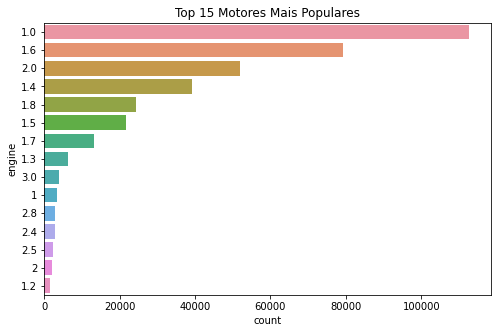

In [20]:
plt.subplots(figsize=(8,5))
sns.countplot(y = car['engine'], order=car['engine'].value_counts().nlargest(15).index).set_title('Top 15 Motores Mais Populares');

### Ano do modelo

Automóveis diminuem gradativamente de preço conforme vão ficando mais velhos, desde o presente até cerca de 1990. Carros mais antigos do que 1990, no entanto, subvertem essa tendência, e seus preços podem variar bastante. Carros dos anos 1950-60 podem chegar até a ser mais caros do que carros atuais. Podemos colocar algumas hipóteses para isso:
- Carros antigos preservados valem mais por sua raridade e acabam virando objeto de colecionador.
- Carros antigos adquirem grande valor emocional, que é convertido no preço.
- Carros antigos podem ter passado por reformas valorizadoras (troca de motor, pintura, etc.)

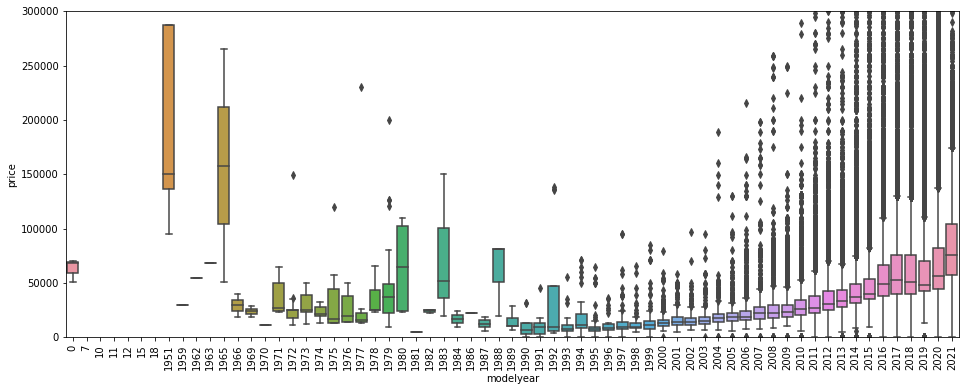

In [21]:
#box plot price/modelyear
data = pd.concat([car['price'], car['modelyear']], axis=1)
f, ax = plt.subplots(figsize=(16, 6))
fig = sns.boxplot(x='modelyear', y='price', data=data)
fig.axis(ymin=0, ymax=300000)
plt.xticks(rotation=90);

## Preparação



### createdat
Como a Tabela Fipe é atualizada mensalmente, devemos verificar se nossos dados de preço estão organizados temporalmente ('atualizados'). Para isso, limpamos a primeira coluna **createdat**:

In [22]:
import re
search = []    
for values in car['createdat']:
    search.append(re.search(r'^.{0,10}', values).group()) # regex para selecionar os 10 primeiros caracteres do string

car['creation_date'] = search
car['creation_date'].unique()

array(['2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04',
       '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
       '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12',
       '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16',
       '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20',
       '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24',
       '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28',
       '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01',
       '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05',
       '2020-11-06', '2020-11-07', '2020-11-08', '2020-11-09',
       '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13',
       '2020-11-14', '2020-11-15', '2020-11-16', '2020-11-17',
       '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21',
       '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25',
       '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29',
       '2020-11-30', '2020-12-01', '2020-12-02', '2020-

Os dados foram extraídos em várias datas diferentes. Seria interessante verificar se, em cada data indicada, os mesmos modelos de carro foram atualizados com valores diferentes.

In [23]:
search = []    
for values in car['createdat']:
    search.append(re.search(r'^.{0,7}', values).group()) # regex para selecionar os 7 primeiros caracteres do string

car['creation_month'] = search
car['creation_month'].unique()

array(['2020-10', '2020-11', '2020-12'], dtype=object)

Desta forma, existe uma proporcionalidade entre os dados mensais. No entanto, os dados não são equilibrados, i.e. não possuem a mesma quantidade de dados para cada categoria. Portanto, existe uma certa assimetria 'horizontal' dos dados, mas não sabemos se isso pode atrapalhar a análise. 

Se analisássemos dados históricos teríamos que considerar o efeito da inflação nas variáveis. Porém, como os dados estão distribuídos ao longo de apenas três meses conseguintes, podemos considerar, em primeira instância, que a inflação dos preços não surtiu tanto efeito na distribuição dos preços.

Para continuarmos nossa modelagem de dados, vamos conferir o uso de memória do dataset antigo `car` e do dataset já preparado, `df_final`.

#### Dados nulos e infinitos

In [24]:
total = car.isnull().sum().sort_values(ascending=False)
percent = (car.isnull().sum()/car.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentagem'])
missing_data.head(5)

,Total,Porcentagem
fipe_price,22627,0.058641
engine,6941,0.017989
km,2664,0.006904
price,236,0.000612
creation_month,0,0.000000


A porcentagem de dados nulos é bem baixa. Dados nulos também ocorrem em apenas quatro variáveis (a variável `creation_month` e todas as outras variáveis fora da tabela não possuem dados nulos). Como a quantidade de dados nulos é baixa (<0.058), se apagarmos estes dados, nossa análise será pouco afetada.

In [25]:
car.isnull().sum().max()

22627

In [26]:
# lidando com dados nulos
car.dropna(axis=0, how='any')

# lidando com dados infinitos
with pd.option_context('mode.use_inf_as_null', True):
    car = car.dropna()

#### Outliers

Também devemos nos manter atentos a outliers. Nos gráficos anteriores, precisamos limitar os eixos x e y, pois diversos veículos chegam a valores muito altos que beiram o irreal, muitas vezes devido a variáveis incomensuráveis, como o apego emocional ao carro. No entanto, para fazer nosso modelo funcionar, devemos nos apegar a fundamentos de valor mais concretos. Assim, podemos fazer uma análise univariada utilizando `StandardScaler` para estabelecer um limiar que define uma observação como um outlier.

In [27]:
from sklearn.preprocessing import StandardScaler

#standardizing data
saleprice_scaled = StandardScaler().fit_transform(car['price'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-0.03199464]
 [-0.03199464]
 [-0.03199464]
 [-0.03199464]
 [-0.03199464]
 [-0.03199464]
 [-0.03199464]
 [-0.03199464]
 [-0.03199464]
 [-0.03199464]]

outer range (high) of the distribution:
[[  1.03297048]
 [  1.03297048]
 [  1.07062076]
 [  1.19970745]
 [  1.25349356]
 [  1.25349356]
 [  1.3610658 ]
 [  1.58158888]
 [ 59.73035824]
 [597.59156   ]]


A faixa superior de valores contém valores muito altos, como 59.73 e 597.59, que certamente nos trarão problemas.

In [28]:
car = car.sort_values(by='price', ascending=False).iloc[2:] # deletando os dois outliers

In [29]:
car.sort_values(by='price', ascending=False).head()

,createdat,make,model,modelyear,fipe_price,price,km,region,phonearea,color,engine,bodystyle,fuel,creation_date,creation_month
357098,2020-12-20T10:03:15Z,Lamborghini,Huracán,2019,2785120.0,3000000.0,6758.0,SP,15,Azul,5.2,Coupê,Gasolina,2020-12-20,2020-12
138756,2020-11-01T05:54:20Z,Ferrari,488 GTB,2018,2020310.0,2590000.0,755.0,SP,11,Preto,3.9,Conversível,Gasolina,2020-11-01,2020-11
141356,2020-11-01T08:44:00Z,Ferrari,488 GTB,2017,1958950.0,2390000.0,2987.0,SP,15,Branco,3.9,Conversível,Gasolina,2020-11-01,2020-11
204104,2020-11-15T10:23:25Z,Ferrari,488 GTB,2017,1958950.0,2390000.0,2987.0,SP,15,Branco,3.9,Conversível,Gasolina,2020-11-15,2020-11
233635,2020-11-22T12:24:01Z,Mercedes-Benz,G 63 AMG,2020,1214720.0,2290000.0,0.0,SP,11,Branco,4.0,SUV,Gasolina,2020-11-22,2020-11


A faixa inferior de valores é muito próxima a zero. Teoricamente, não teríamos problemas. No entanto, carros "de graça" podem atrapalhar a simetria do nosso modelo assim como valores nulos. Portanto, vamos considerar apenas carros acima de um determinado valor, i.e. 10 reais.

In [30]:
car = car[car['price'] > 10]
car.shape

(358386, 15)

In [31]:
car.sort_values(by='price', ascending=True).head()

,createdat,make,model,modelyear,fipe_price,price,km,region,phonearea,color,engine,bodystyle,fuel,creation_date,creation_month
349538,2020-12-18T12:15:57Z,Fiat,Palio,1997,7121.0,4500.0,257000.0,SP,11,Azul,1,Hatch,Gasolina,2020-12-18,2020-12
321129,2020-12-11T08:44:26Z,Fiat,Uno Mille,1996,6568.0,4900.0,999999.0,PR,41,Cinza,1,Hatch,Gasolina,2020-12-11,2020-12
95288,2020-10-22T17:46:44Z,Fiat,Uno Furgão,1998,5754.0,4990.0,100.0,SC,47,Branco,1.5,Van/Furgão,Gasolina,2020-10-22,2020-10
368904,2020-12-23T11:40:55Z,Hyundai,HB20S,2021,56325.0,5000.0,0.0,SP,14,Branco,1.0,Sedan,Flex,2020-12-23,2020-12
361877,2020-12-21T16:50:51Z,Renault,Clio,2005,9685.0,5890.0,220000.0,SP,11,Verde,1.0,Hatch,Gasolina,2020-12-21,2020-12


Assim, os preços condizem com a realidade. Um Fiat Palio de 1997 por R$ 4500 (bem abaixo do preço da Tabela Fipe) parece legítimo.

Além disso, vimos na análise exploratória de dados que, além de `price`, dados como `fipe_price`, `km` e `modelyear` também precisam ser limpos e ajustados. 
- `price` e `fipe_price`: consideraremos apenas preços abaixo de 1 milhão de reais.
- `modelyear`: consideraremos apenas modelos criados após 1950. 
- `km`: consideraremos apenas quilometragens menores do que 8000000 km (um número aleatório equivalente a cerca de 20 voltas equatoriais ao redor da Terra).

In [32]:
car = car[car['price'] < 1000000]
car = car[car['fipe_price'] < 1000000]
car = car[car['modelyear'] > 1949]
car = car[car['km'] < 800000]
car.shape

(357368, 15)

In [33]:
car.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357368 entries, 127116 to 349538
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   createdat       357368 non-null  object 
 1   make            357368 non-null  object 
 2   model           357368 non-null  object 
 3   modelyear       357368 non-null  int64  
 4   fipe_price      357368 non-null  float64
 5   price           357368 non-null  float64
 6   km              357368 non-null  float64
 7   region          357368 non-null  object 
 8   phonearea       357368 non-null  int64  
 9   color           357368 non-null  object 
 10  engine          357368 non-null  object 
 11  bodystyle       357368 non-null  object 
 12  fuel            357368 non-null  object 
 13  creation_date   357368 non-null  object 
 14  creation_month  357368 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 43.6+ MB


Variáveis como `modelyear` e `phonearea` são inicialmente percebidas como numéricas. No entanto, são variáveis categóricas.

In [34]:
car['modelyear'] = car['modelyear'].astype('category')
car['phonearea'] = car['phonearea'].astype('category')

In [35]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(car, test_size=0.2, random_state=42)

## Modelagem de dados

O modelo de regressão com dados em painel (*stacked regression*) foi escolhido pois:
1. É um modelo caixa-branca, isto é, um modelo em que podemos explicar com detalhe como funcionam seus mecanismos internos de cálculo de variáveis. Em contraste, modelos caixa-preta, como Random Forest e Redes Neurais, possuem um alto nível de opacidade e dependência de processos aleatórios. Apesar de modelos caixa-preta serem pervasivos e muito úteis na área de Ciência de Dados e Machine Learning, existe uma tendência no mundo das finanças a utilizar algoritmos caixa-branca para prever preços, devido a questões de transparência fiscal e sensitividade orçamentária.

#### Variável-alvo (*target variable*)

Como nosso objetivo é prever a variável-alvo `price`, vamos destrinchá-la um pouco.


 mu = 56374.48 e sigma = 41579.56



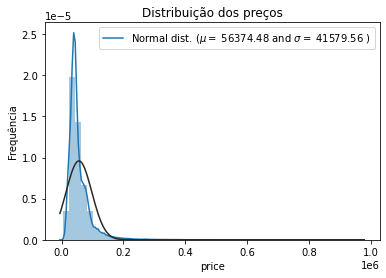

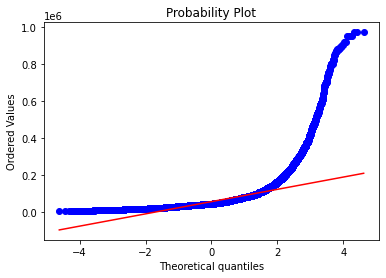

In [36]:
from scipy import stats
from scipy.stats import norm, skew

sns.distplot(car['price'] , fit=norm);

# Obter parâmetros da função
(mu, sigma) = norm.fit(car['price'])
print( '\n mu = {:.2f} e sigma = {:.2f}\n'.format(mu, sigma))

# Plotar
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequência')
plt.title('Distribuição dos preços')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(car['price'], plot=plt)
plt.show()

Como observado anteriormente, temos uma forte assimetria para a esquerda. Veículos mais caros tendem a variar de preço mais acentuadamente (à direita). No entanto, para utilizarmos um modelo de regressão linear, precisamos transformar essa variável de modo a deixá-la em distribuição normal.

#### Transformação logarítmica


 mu = 10.79 e sigma = 0.52



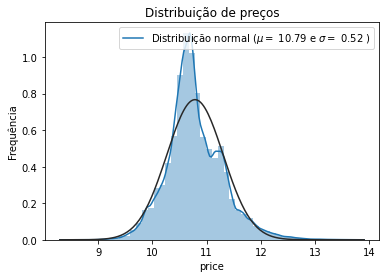

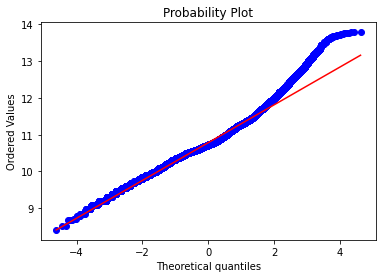

In [37]:
# Log transformation

car["price"] = np.log1p(car["price"])

sns.distplot(car['price'] , fit=norm);

# Obter parâmetros da função
(mu, sigma) = norm.fit(car['price'])
print( '\n mu = {:.2f} e sigma = {:.2f}\n'.format(mu, sigma))

# Plotar
plt.legend(['Distribuição normal ($\mu=$ {:.2f} e $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequência')
plt.title('Distribuição de preços')

# QQ-plot
fig = plt.figure()
res = stats.probplot(car['price'], plot=plt)
plt.show()

Parece difícil normalizar os dados, mesmo com os outliers eliminados. A distribuição continua ligeiramente assimétrica para a direita. Isso acontece porque os carros de valores mais altos fogem bastante do padrão linear da maioria do mercado. Vamos continuar testando o modelo a partir dessa transformação; mas é importante destacar que, caso o modelo dê errado, este será um importante ponto para voltarmos e ajustarmos.

#### Assimetria das variáveis numéricas

In [38]:
# avaliar dataset inteiro
numeric_feats = car.dtypes[car.dtypes == "float64"].index

# checar assimetria das variáveis numéricas
skewed_feats = car[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness

,Skew
fipe_price,4.962508
km,1.854342
price,0.596179


#### Transformação Box Cox de elementos altamente assimétricos


In [39]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    car[feat] = boxcox1p(car[feat], lam)

There are 3 skewed numerical features to Box Cox transform


#### Dummy categorical features

In [40]:
print('Tipos diferentes de fabricantes no dataset:', len(car['make'].unique()))
print('Tipos diferentes de modelos no dataset:', len(car['model'].unique()))
print('Anos diferentes no dataset:', len(car['modelyear'].unique()))
print('Estados diferentes no dataset:', len(car['region'].unique()))
print('Áreas telefônicas diferentes no dataset:', len(car['phonearea'].unique()))
print('Cores diferentes no dataset:', len(car['color'].unique()))
print('Tipos diferentes de motores no dataset:', len(car['engine'].unique()))
print('Tipos de veículos diferentes no dataset:', len(car['bodystyle'].unique()))
print('Tipos de combustíveis diferentes no dataset:', len(car['modelyear'].unique()))
print('Meses diferentes em que os dados foram capturados da Tabela Fipe:', len(car['creation_month'].unique()))

Tipos diferentes de fabricantes no dataset: 46
Tipos diferentes de modelos no dataset: 539
Anos diferentes no dataset: 28
Estados diferentes no dataset: 27
Áreas telefônicas diferentes no dataset: 65
Cores diferentes no dataset: 18
Tipos diferentes de motores no dataset: 52
Tipos de veículos diferentes no dataset: 9
Tipos de combustíveis diferentes no dataset: 28
Meses diferentes em que os dados foram capturados da Tabela Fipe: 3


Ao restringirmos veículos de preço muito alto, diminuímos consideravelmente a quantidade de tipos diferentes de motores (de 209 tipos detectados anteriormente para 52 tipos agora). Isso indica que carros muito caros tendem a possuir motores diferenciados.

Para criarmos uma matriz esparsa com base nessas variáveis categóricas, vamos reduzir a memória utilizada por estes dados. O `pandas` permite a conversão de arquivos tipo `object` para `category`, como uma transformação maquiada de `str` para `int`, o que reduz uso de memória.

In [41]:
carcat = car.drop(['fipe_price', 'price', 'km', 'createdat', 'creation_date'], axis=1)
car_cat = carcat.astype('category')
car_cat = pd.get_dummies(car_cat)
carcat2 = car[['fipe_price', 'price', 'km']]
df_final = pd.concat([car_cat, carcat2], axis=1, join="inner")
df_final.shape

(357368, 793)

In [42]:
car.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357368 entries, 127116 to 349538
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   createdat       357368 non-null  object  
 1   make            357368 non-null  object  
 2   model           357368 non-null  object  
 3   modelyear       357368 non-null  category
 4   fipe_price      357368 non-null  float64 
 5   price           357368 non-null  float64 
 6   km              357368 non-null  float64 
 7   region          357368 non-null  object  
 8   phonearea       357368 non-null  category
 9   color           357368 non-null  object  
 10  engine          357368 non-null  object  
 11  bodystyle       357368 non-null  object  
 12  fuel            357368 non-null  object  
 13  creation_date   357368 non-null  object  
 14  creation_month  357368 non-null  object  
dtypes: category(2), float64(3), object(10)
memory usage: 245.0 MB


In [43]:
df_final.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357368 entries, 127116 to 349538
Columns: 793 entries, make_Audi to km
dtypes: float64(3), uint8(790)
memory usage: 290.1 MB


Ambos os datasets fazem o mesmo uso de memória, mesmo `car` possuindo 15 colunas e `df_final`, 793 colunas.

## Modelagem de dados

Iremos testar os seguintes algoritmos:
- Lasso
- Elastic Net
- Stochastic Gradient Descent
- Light Gradient Boosting Machine

#### Scores

In [44]:
from sklearn.linear_model import ElasticNet, Lasso, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb

In [45]:
target = df_final['price']
features = df_final.drop('price', axis = 1)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [48]:
lasso = make_pipeline(RobustScaler(), Lasso())
ENet = make_pipeline(RobustScaler(), ElasticNet())
sgd_reg = make_pipeline(RobustScaler(), SGDRegressor(n_iter_no_change=50, penalty=None, eta0=0.1))
model_lgb = make_pipeline(RobustScaler(), lgb.LGBMRegressor())

In [50]:
lasso.fit(X_train,y_train)
score = lasso.score(X_test, y_test)
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Lasso score:", score)
print("Lasso mean squared error:", mse)
print("Lasso mean absolute error:", mae)

Lasso score: -1.3299847295256129e-05
Lasso mean squared error: 0.004031614357809993
Lasso mean absolute error: 0.04816200464654519


In [51]:
ENet.fit(X_train,y_train)
score = ENet.score(X_test, y_test)
y_pred = ENet.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Elastic Net score:", score)
print("Elastic Net mean squared error:", mse)
print("Elastic Net mean absolute error:", mae)

Elastic Net score: -1.3299847295256129e-05
Elastic Net mean squared error: 0.004031614357809993
Elastic Net mean absolute error: 0.04816200464654519


In [52]:
sgd_reg.fit(X_train,y_train)
score = sgd_reg.score(X_test, y_test)
y_pred = sgd_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("SGD score:", score)
print("SGD mean squared error:", mse)
print("SGD mean absolute error:", mae)

SGD score: 0.9713839601072538
SGD mean squared error: 0.00011536730292774748
SGD mean absolute error: 0.007594748849062891


In [53]:
model_lgb.fit(X_train,y_train)
score = model_lgb.score(X_test, y_test)
y_pred = model_lgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("LGBM score:", score)
print("LGBM mean squared error:", mse)
print("LGBM mean absolute error:", mae)

LGBM score: 0.9762156874523118
LGBM mean squared error: 9.588790066346373e-05
LGBM mean absolute error: 0.006755775386300297
